# Assignment 6: Solow Class
Kiran Ferrini

In [1]:
%matplotlib inline
from fredapi import Fred
fred = Fred(api_key = '91d55a1617750e1cc9dadb64d1e4c679')
import statsmodels.api as sm
import pandas as pd
import numpy as np 
import pandas_datareader as pdr
import datetime
import scipy.stats
import sympy
from sympy import *
import matplotlib.pyplot as plt
from tabulate import tabulate
plt.rcParams['figure.figsize'] = [12,8]

pwtdata = pd.read_excel('pwt100.xlsx', 2) # outside of class for speed purposes, dont need to load the same file every time. It can be put inside easily if need be

class solow_class():
    
    def __init__(self, ISO, rho = 0.0, A = None, reg = False, start = [1954, 1, 1], end = [2019, 10, 1]):
        
        #-----------------Checks to make sure ISO returns a valid DataFrame-----------#
        if isinstance(ISO, str):
            pass
        else:
            raise Exception("ISO must be in string format")
            
        self.df = pwtdata
        self.df = self.df[self.df['countrycode'] == ISO]
        
        if len(self.df) == 0: 
            raise Exception("Invalid ISO Code: Returned empty DF")
        else: 
            pass 
        
        self.ISO = ISO
        
        #-----------FRED Start and End (for later)---------------#
        self.start = start
        self.end = end
        
        #------------Set up DF--------------#
        self.df.index = self.df['year']
        self.df = self.df.dropna(subset = ['rtfpna', 'rgdpna', 'emp', 'rnna', 
                                           'delta', 'csh_i', 'labsh']) # Drop any years with missing values for the variables we use (1950-54)
        if len(self.df) == 0:
            raise Exception("The data is entirely missing for atlest one of the required variables")
        
        #-----------------Define variables-------------------# 
        self.y = self.df['rgdpna'] / self.df['emp'] # Real GDP Per Capita
        self.k = self.df['rnna'] / self.df['emp'] # capital per worker
        self.tfp = self.df['rtfpna'] # total factor productivity 
        
        self.delta = self.df['delta'].mean() # Depreciation rate
        self.s = self.df['csh_i'].mean() # savings rate
        self.a_k = 1 - self.df['labsh'].mean() # capital share  
        self.rho = rho # exogenous - for CES prod fuction
        
        self.Abench = self.df['rtfpna'][2017]  # benchmark TFP in 2017 (A)

        
        #---------Regression(s) to get residuals, n, g------#
        lhv = np.log(self.df['rtfpna'])
        rhv = np.arange(len(lhv))
        rhv = sm.add_constant(rhv)
        self.lrg = sm.OLS(lhv, rhv).fit()
        self.resid = self.lrg.resid
        self.g = self.lrg.params[1]

        lhv2 = np.log(self.df['emp'])
        lrn = sm.OLS(lhv2, rhv).fit()
        self.n = lrn.params[1]
        
        if reg == True:
            print(self.lrg.summary())
        
        self.yhat = self.intensive(k = self.k[2017], A = 1)
        self.A = self.y[2017]/self.yhat

        
    def intensive(self, k, A):
        if self.rho == 0:
            f = lambda k: A*k**self.a_k #prevents division by 0
        else:
            f = lambda k: A*((self.a_k*k**self.rho) + (1 - self.a_k))**(1/self.rho) #general case
        return f(k)
    
    def solow(self, k):
        return (self.s*self.intensive(k = k, A = self.A)) - k*(self.n+self.g+self.n*self.g+self.delta)
    
    def compare(self):
        a = 1 - self.df['labsh']
        yhat = self.tfp * self.k ** a
        A = self.y[2017]/yhat[2017]
        yhat = A * yhat   
        plt.title('Per capita GDP and Model prediction for' + self.ISO)
        plt.ylabel('log of 2017 US $ per worker')
        np.log(self.y).plot(color='blue')
        np.log(yhat).plot(color='red')
        plt.legend(['Data','Prediction'])
        plt.show()
        return
        

    def my_bisection(self, a, b, tol): 
        if np.sign(self.solow(a)) == np.sign(self.solow(b)):
               raise Exception("The scalars a and b do not bound a root")
        m = (a + b)/2       
        if np.abs(self.solow(m)) < tol:
            return m
        elif np.sign(self.solow(a)) == np.sign(self.solow(m)):
            return self.my_bisection(a = m, b = b, tol=tol)
        elif np.sign(self.solow(b)) == np.sign(self.solow(m)):
            return self.my_bisection(a = a, b = m, tol = tol)
        
    
    def steady_state(self, a = 0.1, b = 1000000, tol = 1e-6):
        kbar = self.my_bisection(a = a, b = b, tol = tol)
        ybar = self.intensive(k = kbar, A = self.A)
        x = sympy.symbols('x')
        rbar = sympy.diff(self.intensive(k = x, A = self.A)).subs(x, kbar)
        b_h_life = (1 - self.delta+self.s*float(rbar)) / (1 + self.n + self.n + self.n*self.g)
        h_life= -np.log(2)/np.log(b_h_life) #VERY sensitive 
        return {"country": self.ISO,"ssrental": float(rbar), "sscapshare": float(rbar)*kbar/ybar, 
                "kbar": kbar, "ybar": ybar, "b_half_life": b_h_life, "half_life": h_life}
    
    def compare_USA(self):
        start =  datetime.datetime (self.start[0], self.start[1], self.start[2])
        end =  datetime.datetime (self.end[0], self.end[1], self.end[2])
        var_names = ['GDPC1']
        df_GDP = pdr.DataReader(var_names, 'fred', start, end)
        Y_cycle, Y_trend = sm.tsa.filters.hpfilter(np.log(df_GDP['GDPC1']), 1600)
        df_GDP["Y_Cycle"]=Y_cycle
        compData = df_GDP.groupby(df_GDP.index.year)['Y_Cycle'].mean()
        if len(compData) == len(self.df):
            pass
        else:
            raise Exception('Fred dataframe length does not match PWT Data')
        correlation = np.corrcoef(compData, self.resid)[1,0]
        tstat = correlation*np.sqrt(len(compData)-2)/np.sqrt(1 - correlation**2)
        pval = scipy.stats.t.sf(abs(tstat), df = len(compData)-2)
        return {'correlation': correlation, 't-statistic': tstat, 'p-value': pval, 'FRED' : compData}
    
    def summary(self):
        a = 1 - self.df['labsh']
        yhat = self.tfp * self.k ** a
        A = self.y[2017]/yhat[2017]
        yhat = A * yhat   
        correlation = np.corrcoef(self.y, yhat)[1,0]
        tstat = correlation*np.sqrt(len(self.y)-2)/np.sqrt(1 - correlation**2)
        pval = scipy.stats.t.sf(abs(tstat), df = len(self.y)-2)
        rr, share, kbar, ybar = self.steady_state()["ssrental"], self.steady_state()["sscapshare"], self.steady_state()["kbar"], self.steady_state()["ybar"]
        bhl, hl =  self.steady_state()["b_half_life"], self.steady_state()["half_life"]
        corr, ts, pv = self.compare_USA()["correlation"], self.compare_USA()["t-statistic"], self.compare_USA()["p-value"]
        tablevars = [['Country', 'A', 'δ', 's', 'α', 'n', 'g', 'Steady-State Capital', 'Steady-State Rental Rate', 'Steady-State Y', 'Steady-State Capital Share'],
                     [self.ISO, self.A, self.delta, self.s, self.a_k, self.n, self.g, kbar, rr, ybar, share]]
        tablehl = [['Half Life B', 'Half Life'], [bhl, hl]]
        tabledatacomp = [['Real Data Correlation', 'T-Stat', 'P-Value'],[correlation, tstat, pval]]
        tablefred = [['FRED Data Correlation', 'T-Stat', 'P-Value'], [corr, ts, pv]]
        print(tabulate(tablevars, headers='firstrow', tablefmt='fancy_grid'))
        print(tabulate(tablehl, headers='firstrow', tablefmt='fancy_grid'))
        print(tabulate(tabledatacomp, headers='firstrow', tablefmt='fancy_grid'))
        print(tabulate(tablefred, headers='firstrow', tablefmt='fancy_grid'))
        return
    
    def plots(self):
        a = 1 - self.df['labsh']
        yhat = self.tfp * self.k ** a
        A = self.y[2017]/yhat[2017]
        yhat = A * yhat   
        compData = self.compare_USA()['FRED']
      
        
        plt.rcParams['figure.figsize'] = (16,25)
        fig, [ax1, ax2, ax3] = plt.subplots(3, 1, sharex=False)
        
        fig.suptitle('Interesting Solow Class Plots', fontsize=24)

        ax1.hist(self.resid, rwidth = 0.97, density = True)
        ax1.set_title('Error Terms from TFP Regression for ' + self.ISO)
        ax1.set_xlabel('Residuals')
        

        ax2.set_title('Per capita GDP and Model prediction for ' + self.ISO)
        ax2.set_ylabel('log of 2017 US Dollars per Worker')
        ax2.plot(np.log(self.y), color = 'blue')
        ax2.plot(np.log(yhat), color = 'red')
        ax2.legend(['Data','Prediction'], loc = 'upper left', fontsize = 'xx-large')
        
        ax3.set_title('Solow Residuals and Y_Cycle from FRED')
        ax3.set_ylabel('% Change')
        ax3.plot(compData, color = 'blue')
        ax3.plot(self.resid, color = 'red')
        ax3.legend(['FRED Data', 'Solow Residuals'], fontsize = 'xx-large')

        fig.tight_layout(pad=5.0)
        plt.show()
        return

# Class in Action
## Important Note
**g** and **n** are calculated using regressions as opposed to the average/endpoint method in Fisher's notebook. As such the values--while still very similar--are not exactly the same. The biggest difference can be found when calculating the half-life because the half-life is **VERY** sensitive to slight changes in **b**. 

In [10]:
solow_example = solow_class('USA', rho = 0, reg = True)

                            OLS Regression Results                            
Dep. Variable:                 rtfpna   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     2054.
Date:                Mon, 20 Feb 2023   Prob (F-statistic):           2.34e-50
Time:                        17:21:24   Log-Likelihood:                 161.45
No. Observations:                  66   AIC:                            -318.9
Df Residuals:                      64   BIC:                            -314.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3836      0.005    -74.047      0.0

## Steady State Values and Stats

In [3]:
solow_example.summary()

╒═══════════╤═════════╤═══════════╤══════════╤══════════╤═══════════╤════════════╤════════════════════════╤════════════════════════════╤══════════════════╤══════════════════════════════╕
│ Country   │       A │         δ │        s │        α │         n │          g │   Steady-State Capital │   Steady-State Rental Rate │   Steady-State Y │   Steady-State Capital Share │
╞═══════════╪═════════╪═══════════╪══════════╪══════════╪═══════════╪════════════╪════════════════════════╪════════════════════════════╪══════════════════╪══════════════════════════════╡
│ USA       │ 4888.89 │ 0.0359584 │ 0.245609 │ 0.381945 │ 0.0141359 │ 0.00623311 │                 572477 │                  0.0323854 │           131496 │                     0.140992 │
╘═══════════╧═════════╧═══════════╧══════════╧══════════╧═══════════╧════════════╧════════════════════════╧════════════════════════════╧══════════════════╧══════════════════════════════╛
╒═══════════════╤═════════════╕
│   Half Life B │   Half Life │
╞

## Plots

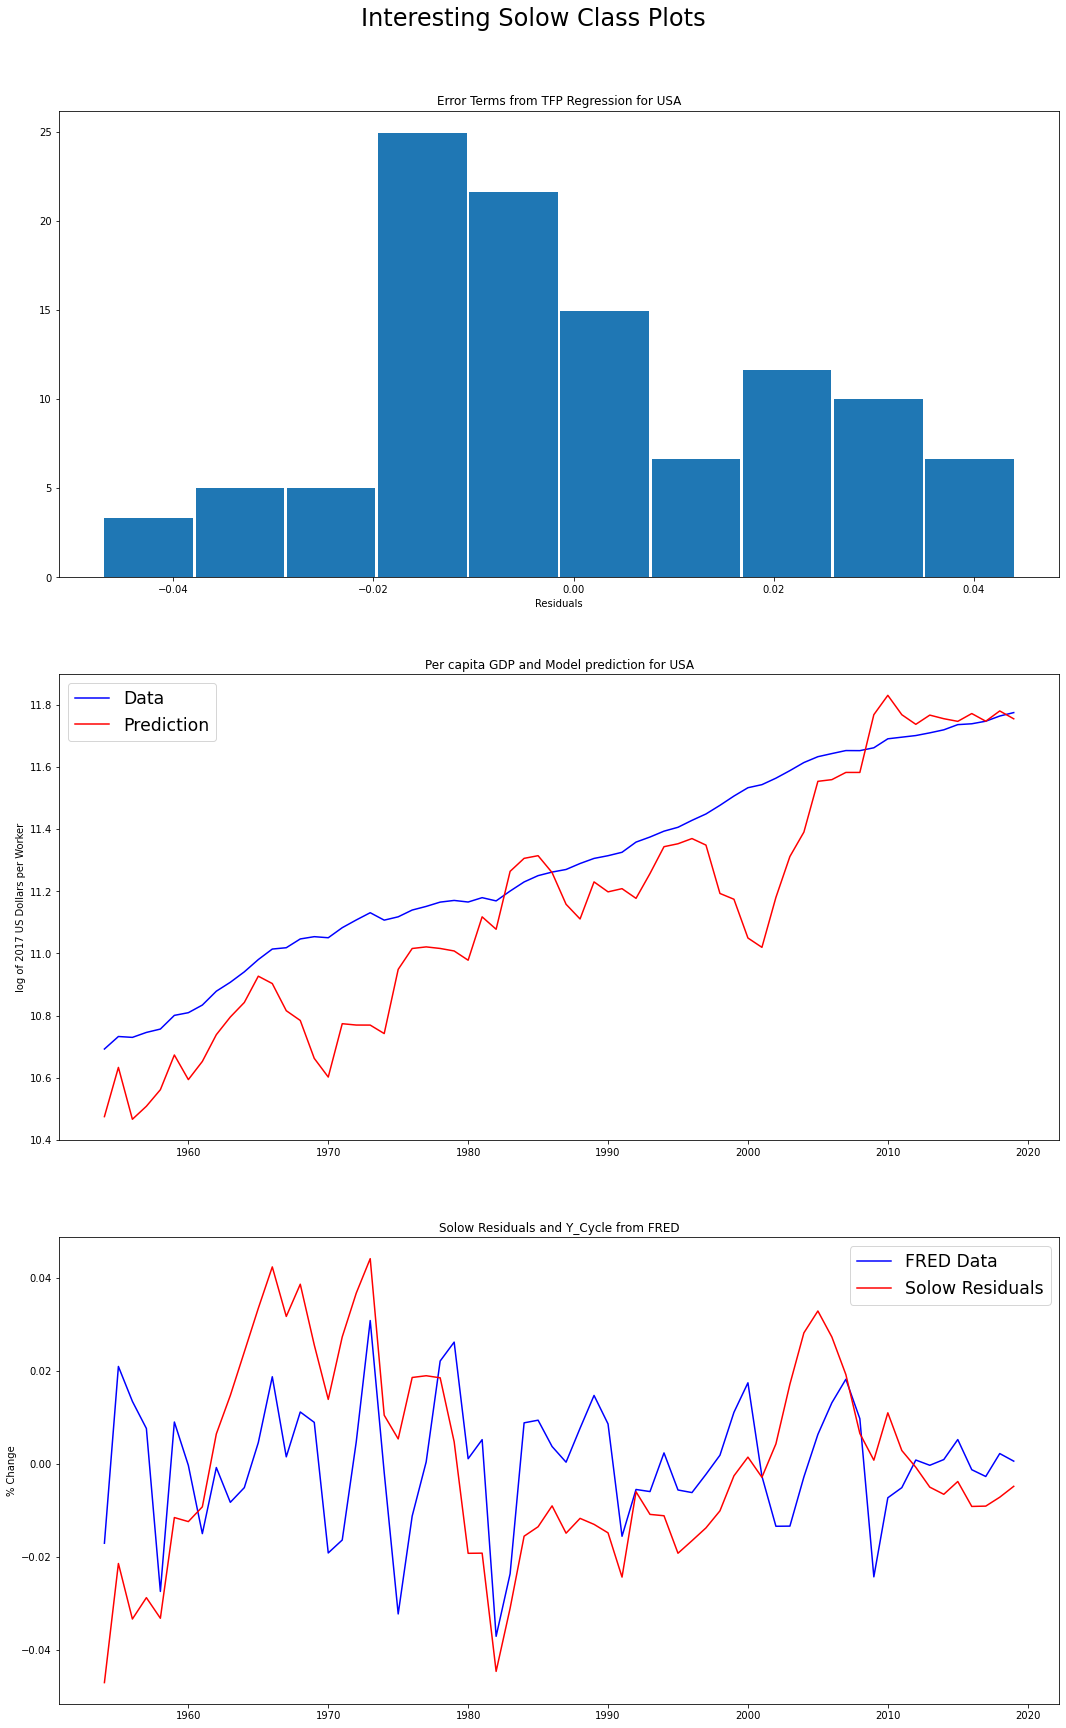

In [4]:
solow_example.plots()

## Initialization Failures
Invalid ISO:

In [5]:
solow_fail1 = solow_class('FISHERLAND', rho = 0, reg = True)

Exception: Invalid ISO Code: Returned empty DF

Invalid ISO Input Type: 

In [6]:
solow_fail2 = solow_class(113, rho = 0, reg = True)

Exception: ISO must be in string format

Country with Fully Missing Data (Malawi):  
*missing TFP data*

In [7]:
malawi_solow = solow_class('MWI', rho = 0, reg = True)

Exception: The data is entirely missing for atlest one of the required variables

In [8]:
 pwtdata[pwtdata['countrycode'] == 'MWI']['rtfpna']

8400   NaN
8401   NaN
8402   NaN
8403   NaN
8404   NaN
        ..
8465   NaN
8466   NaN
8467   NaN
8468   NaN
8469   NaN
Name: rtfpna, Length: 70, dtype: float64

**Important to note:** This class drops any year with missing data in *ANY* of the variables of interest. This 

## Different Country: UK

                            OLS Regression Results                            
Dep. Variable:                 rtfpna   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     1304.
Date:                Mon, 20 Feb 2023   Prob (F-statistic):           2.82e-44
Time:                        17:20:57   Log-Likelihood:                 142.45
No. Observations:                  66   AIC:                            -280.9
Df Residuals:                      64   BIC:                            -276.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3743      0.007    -54.173      0.0

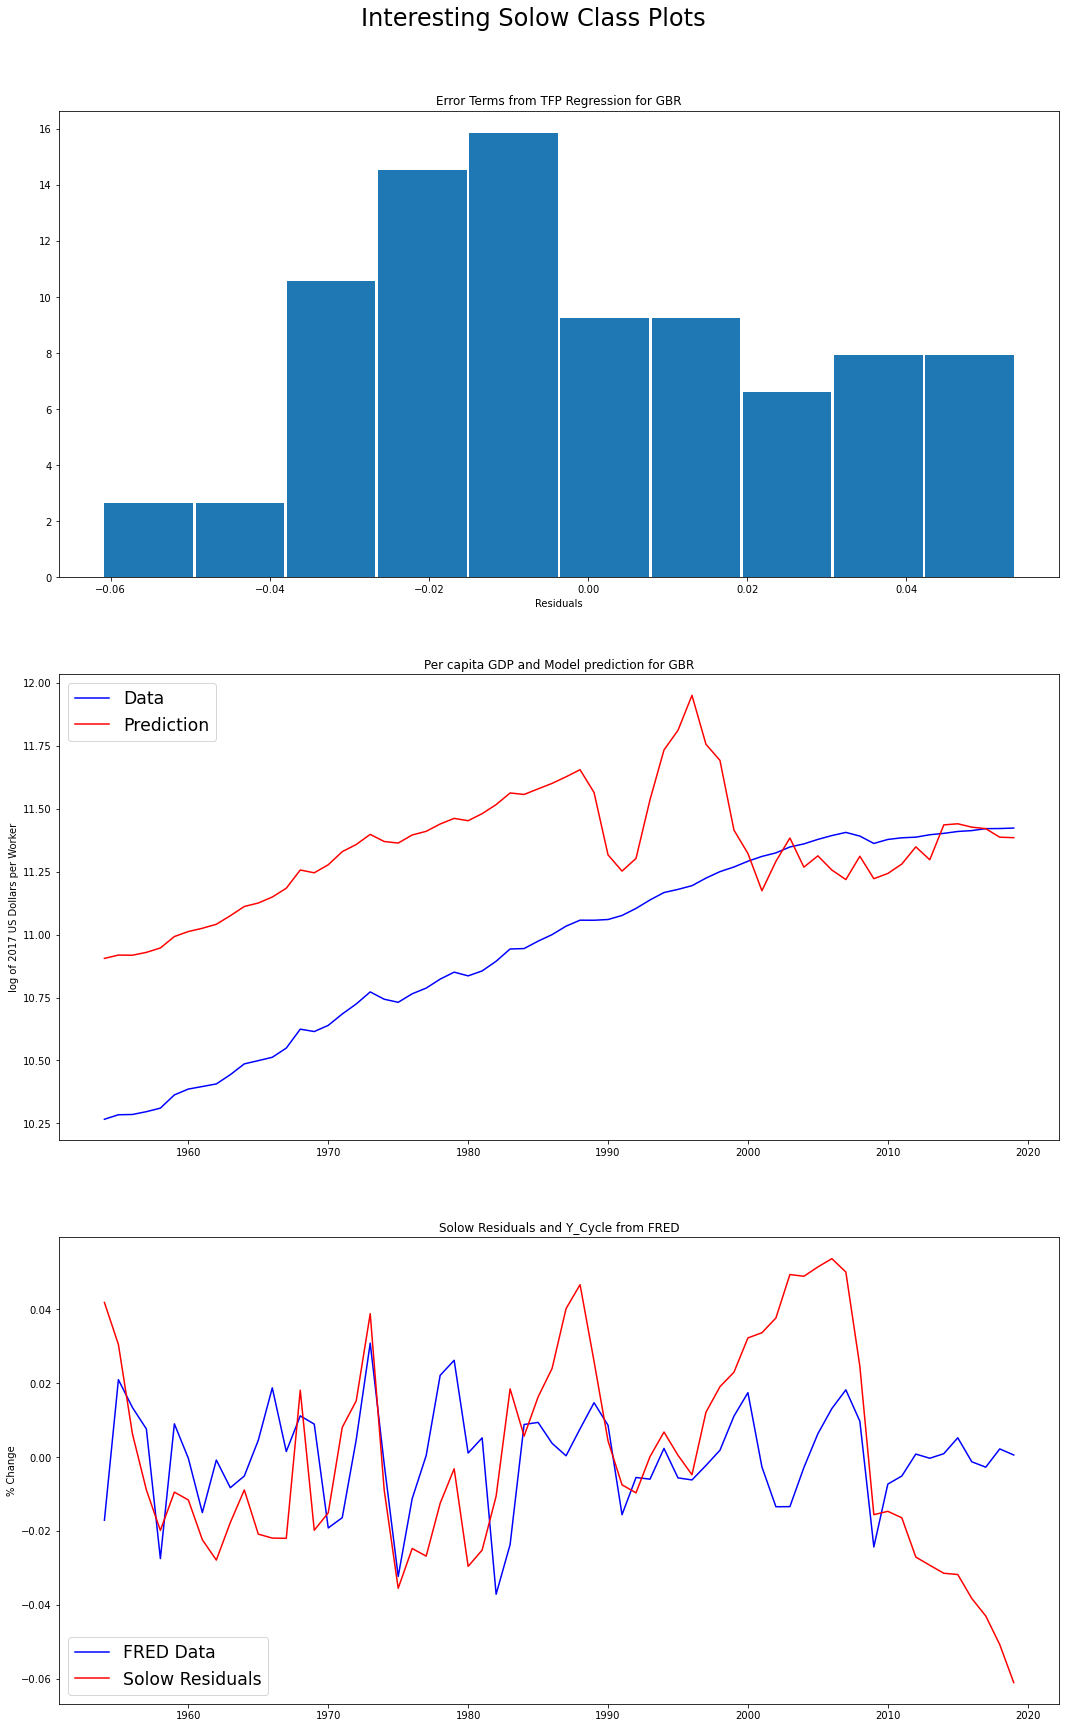

In [9]:
uk_solow = solow_class('GBR', rho = 0, reg = True)
uk_solow.summary()
uk_solow.plots()